In [5]:
import torch 
import torchvision
from torchvision import datasets, transforms # standard pkg that has datasets and transforms
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
"""
Import functional modules and neural networl impl from Pytorch
"""
from torch import nn
import torch.nn.functional as F

In [6]:
"""
When normalizing images, make sure to write as

transforms.Normalize((0.5,), (0.5,)) - correct

Not as

transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
"""

'\nWhen normalizing images, make sure to write as\n\ntransforms.Normalize((0.5,), (0.5,)) - correct\n\nNot as\n\ntransforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n'

In [7]:
transform = transforms.Compose([transforms.Resize((28,28)), # resize for validation
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# training_dataset     
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# validation dataset
# mainly for testing purposes
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [8]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [9]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # convert data into numpy array
    image = image.transpose(1, 2, 0)
#    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

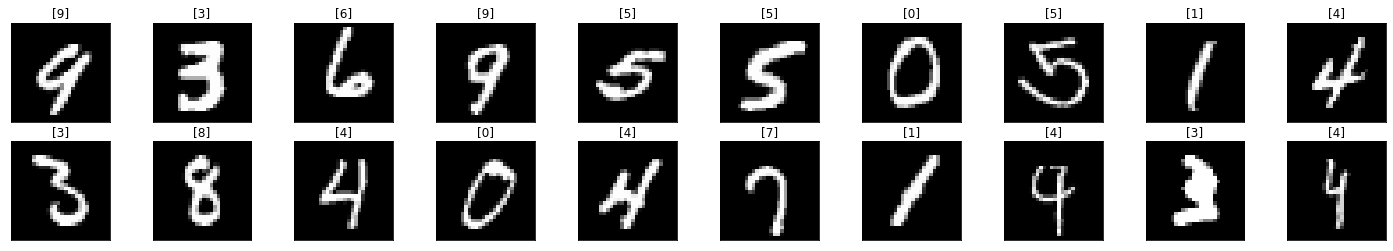

In [10]:
# Create object that allows iterable to run
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [11]:
# Neural Network Implementation on Image Recog (S7 #7) - 09162020
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out): # n of input node, no. of nodes in 1st input layer, no. of nodes in 2nd input layer, no. of nodes in output layer
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, X): 
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X) # raw output (score) of the network, nn.CrossEntropyLoss
        return X

In [12]:
model = Classifier(784, 125, 65, 10) # 28 px * 28 px = 784 pixels for MNIST(784 nodes necesary)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # tips, start with a high learning rate then adjust based on results whether loss fluctuates or not (skewness)

In [14]:
epochs = 15
running_loss_history = []
running_corrects_history = []
# validation running history
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
            
    running_loss = 0.0
    running_corrects = 0.0     
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        # save memory
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
            
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print("epoch: ", e+1)
    
        if(e == 14):
            print("Finished!")

        print("training loss: {:.4f}, training correct: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation correct: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))        

epoch:  1
training loss: 0.9354, training correct: 78.5400
validation loss: 0.4187, validation correct: 88.9700
epoch:  2
training loss: 0.3764, training correct: 89.4350
validation loss: 0.3185, validation correct: 90.9400
epoch:  3
training loss: 0.3136, training correct: 91.0383
validation loss: 0.2823, validation correct: 92.0700
epoch:  4
training loss: 0.2814, training correct: 91.8300
validation loss: 0.2576, validation correct: 92.4800
epoch:  5
training loss: 0.2583, training correct: 92.5750
validation loss: 0.2421, validation correct: 92.8900
epoch:  6
training loss: 0.2397, training correct: 93.0950
validation loss: 0.2334, validation correct: 93.3700
epoch:  7
training loss: 0.2221, training correct: 93.6067
validation loss: 0.2120, validation correct: 93.7800
epoch:  8
training loss: 0.2073, training correct: 94.0367
validation loss: 0.2029, validation correct: 94.1200
epoch:  9
training loss: 0.1930, training correct: 94.3950
validation loss: 0.1844, validation correct: 

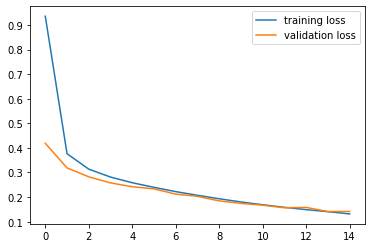

In [15]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
#plt.plot(running_corrects_history, label="training accuracy")

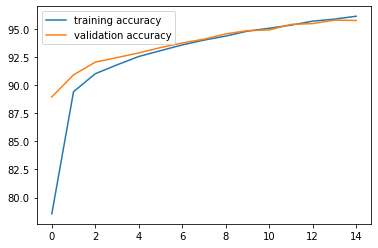

In [16]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")
plt.legend()

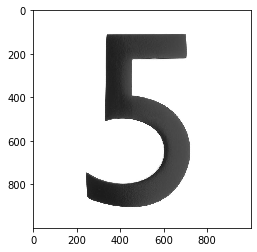

In [24]:
# Final tests (09222020)
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
#print(response)

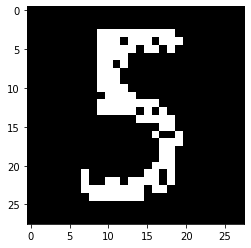

In [25]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [26]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


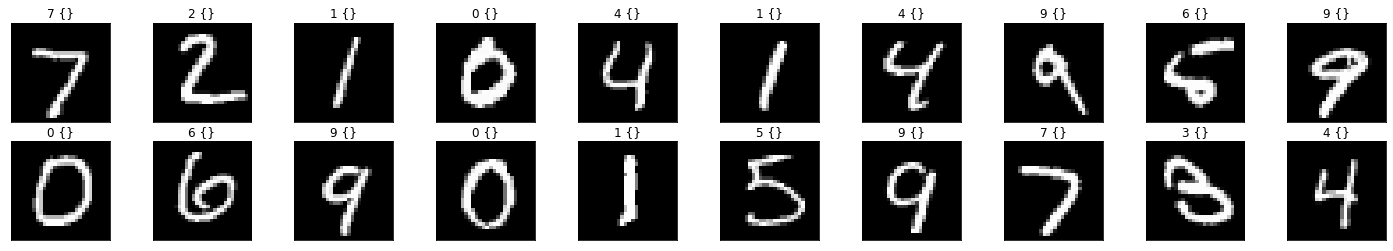

In [30]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} {{}}".format(str(preds[idx].item()), str(labels[idx].item()), color=("green" if preds[idx]==labels[idx] else "red")))